In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, confusion_matrix, accuracy_score, f1_score, precision_score
import time
from sklearn.neural_network import MLPClassifier
from sklearn import ensemble, preprocessing
from sklearn.svm import SVC, LinearSVC
import matplotlib.pyplot as plt
from my_functions import *
from sklearn.utils import shuffle
from sklearn.calibration import CalibratedClassifierCV

In [2]:
train_labels = pd.read_csv('Data/bci/TrainLabels.csv')
submission = pd.read_csv('Data/bci/SampleSubmission.csv')
true_labels = pd.read_csv('Data/bci/true_labels.csv', header=None)
X_train = np.load('Data/bci/X_train_final.npy')
X_test = np.load('Data/bci/X_test_final.npy')

In [3]:
Y_train = train_labels.Prediction.values
Y_test = true_labels[0].values

In [6]:
Y_train.shape

(5440,)

In [7]:
Y_test.shape

(3400,)

In [8]:
Y = np.concatenate((Y_train,Y_test))
Y.shape

(8840,)

In [9]:
X_train.shape

(5440, 210)

In [10]:
X_test.shape

(3400, 210)

In [12]:
X = np.concatenate((X_train,X_test))
X.shape

(8840, 210)

In [17]:
def RFfunc(x_train1, x_test1, y_train1, y_test1):
    clf = ensemble.RandomForestClassifier(n_jobs = -1, n_estimators=200, 
                                          random_state=42)
    clf.fit(x_train1, y_train1)
    probs_train = clf.predict_proba(x_train1)[:,1]
    t_f1, t_apr, t_acc, t_auc = matrix_info(0.7521, y_train1, probs_train)    
    
    probs = clf.predict_proba(x_test1)[:,1]
    f1, apr, acc, auc = matrix_info(0.6651,y_test1, probs)
    return round(f1,3), round(apr,3), round(acc,3), round(auc,3), round(t_f1,3), round(t_apr,3), round(t_acc,3), round(t_auc,3)

def MLPfunc(x_train1, x_test1, y_train1, y_test1):
    start = time.time()
    mlp = MLPClassifiermlp = MLPClassifier(solver='adam', activation='relu', alpha=0.0001, 
                                           hidden_layer_sizes = (64, 1), max_iter = 10000)
    mlp.fit(x_train1, y_train1)
    probs_train = mlp.predict_proba(x_train1)[:,1]
    t_f1, t_apr, t_acc, t_auc = matrix_info(0.7521, y_train1, probs_train)    
    
    probs = mlp.predict_proba(x_test1)[:,1]
    f1, apr, acc, auc = matrix_info(0.77, y_test1, probs)
    return round(f1,3), round(apr,3), round(acc,3), round(auc,3), round(t_f1,3), round(t_apr,3), round(t_acc,3), round(t_auc,3)

def SVMfunc(x_train1, x_test1, y_train1, y_test1):
    start = time.time()
    svc = SVC(kernel = 'rbf', C = 5, degree = 10, gamma = 0.04, 
              max_iter =  100000, probability = True)
    svc.fit(x_train1, y_train1)
    probs_train = svc.predict_proba(x_train1)[:,1]
    t_f1, t_apr, t_acc, t_auc = matrix_info(0.7521, y_train1, probs_train)    
    
    probs = svc.predict_proba(x_test1)[:,1]
    f1, apr, acc, auc = matrix_info(0.7521,y_test1, probs)
    return round(f1,3), round(apr,3), round(acc,3), round(auc,3), round(t_f1,3), round(t_apr,3), round(t_acc,3), round(t_auc,3)


def LSVMfunc(x_train1, x_test1, y_train1, y_test1):
    start=time.time()
    svc = LinearSVC(C = 5, loss = 'hinge', max_iter=10000)
    svc = CalibratedClassifierCV(svc)
    svc.fit(x_train1,y_train1)
    probs_train = svc.predict_proba(x_train1)[:,1]
    t_f1, t_apr, t_acc, t_auc = matrix_info(0.7521, y_train1, probs_train)
    
    probs = svc.predict_proba(x_test1)[:,1]
    f1, apr, acc, auc = matrix_info(0.7521,y_test1, probs)
    

    now = time.time()
    print('Elapsed Time: ' + str(int(now-start)) + ' seconds')
    return round(f1,3), round(apr,3), round(acc,3), round(auc,3), round(t_f1,3), round(t_apr,3), round(t_acc,3), round(t_auc,3)

In [9]:
rf = np.empty([9, 7])
mlp = np.empty([9, 7])
svm = np.empty([9, 7])
test_sizes = [0.2,0.5,0.8]
X_train = preprocessing.scale(X_train)
X_train,Y_train = shuffle(X_train, Y_train)
j = 0
start1 = time.time()
for size in test_sizes:
    for i in np.arange(3):
        print(size, i)
        x_train1, x_test1, y_train1, y_test1 = train_test_split(X_train, Y_train, test_size=size)
        rf_time = time.time()
        rf_f1, rf_apr, rf_acc, rf_auc = RFfunc(x_train1, x_test1, y_train1, y_test1)
        rf_time = time.time() - rf_time
        
        mlp_time = time.time()
        mlp_f1, mlp_apr, mlp_acc, mlp_auc = MLPfunc(x_train1, x_test1, y_train1, y_test1)
        mlp_time = time.time() - mlp_time
        
        svm_time = time.time()
        svm_f1, svm_apr, svm_acc, svm_auc = LSVMfunc(x_train1, x_test1, y_train1, y_test1)
        svm_time = time.time() - svm_time
        rf[j] = [rf_f1, rf_apr, rf_acc, rf_auc, i, size, rf_time]
        mlp[j] = [mlp_f1, mlp_apr, mlp_acc, mlp_auc, i, size, mlp_time]
        svm[j] = [svm_f1, svm_apr, svm_acc, svm_auc, i, size, svm_time]
        j = j + 1
now1 = time.time()
print('Elapsed Time: ' + str(int(now1-start1)) + ' seconds')

0.2 0
f1_score:
0.6466300176829342
precision_score:
0.6454241071428571
accuracy_score:
0.6773897058823529
Confusion Matrix:
[[208 111]
 [240 529]]
              precision    recall  f1-score   support

           0       0.46      0.65      0.54       319
           1       0.83      0.69      0.75       769

    accuracy                           0.68      1088
   macro avg       0.65      0.67      0.65      1088
weighted avg       0.72      0.68      0.69      1088

f1_score:
0.6447381839649783
precision_score:
0.6421326076199901
accuracy_score:
0.6792279411764706
Confusion Matrix:
[[200 119]
 [230 539]]
              precision    recall  f1-score   support

           0       0.47      0.63      0.53       319
           1       0.82      0.70      0.76       769

    accuracy                           0.68      1088
   macro avg       0.64      0.66      0.64      1088
weighted avg       0.72      0.68      0.69      1088

Elapsed Time: 2 seconds


D:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\Anaconda\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\Anaconda\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


f1_score:
0.6602175754022539
precision_score:
0.6553820300655744
accuracy_score:
0.7003676470588235
Confusion Matrix:
[[194 125]
 [201 568]]
              precision    recall  f1-score   support

           0       0.49      0.61      0.54       319
           1       0.82      0.74      0.78       769

    accuracy                           0.70      1088
   macro avg       0.66      0.67      0.66      1088
weighted avg       0.72      0.70      0.71      1088

Elapsed Time: 8 seconds
0.2 1
f1_score:
0.6583038034490906
precision_score:
0.655910196510753
accuracy_score:
0.6884191176470589
Confusion Matrix:
[[213 109]
 [230 536]]
              precision    recall  f1-score   support

           0       0.48      0.66      0.56       322
           1       0.83      0.70      0.76       766

    accuracy                           0.69      1088
   macro avg       0.66      0.68      0.66      1088
weighted avg       0.73      0.69      0.70      1088

f1_score:
0.6526580597377056
precis

D:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\Anaconda\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\Anaconda\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


f1_score:
0.6393539131426329
precision_score:
0.6527306032370466
accuracy_score:
0.6553308823529411
Confusion Matrix:
[[242  80]
 [295 471]]
              precision    recall  f1-score   support

           0       0.45      0.75      0.56       322
           1       0.85      0.61      0.72       766

    accuracy                           0.66      1088
   macro avg       0.65      0.68      0.64      1088
weighted avg       0.74      0.66      0.67      1088

Elapsed Time: 8 seconds
0.2 2
f1_score:
0.6638026323688848
precision_score:
0.6693906868325473
accuracy_score:
0.6783088235294118
Confusion Matrix:
[[256  90]
 [260 482]]
              precision    recall  f1-score   support

           0       0.50      0.74      0.59       346
           1       0.84      0.65      0.73       742

    accuracy                           0.68      1088
   macro avg       0.67      0.69      0.66      1088
weighted avg       0.73      0.68      0.69      1088

f1_score:
0.642816414686825
precis

D:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\Anaconda\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\Anaconda\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


f1_score:
0.6839242025924294
precision_score:
0.6842411859768285
accuracy_score:
0.7012867647058824
Confusion Matrix:
[[254  92]
 [233 509]]
              precision    recall  f1-score   support

           0       0.52      0.73      0.61       346
           1       0.85      0.69      0.76       742

    accuracy                           0.70      1088
   macro avg       0.68      0.71      0.68      1088
weighted avg       0.74      0.70      0.71      1088

Elapsed Time: 8 seconds
0.5 0
f1_score:
0.6255544068697205
precision_score:
0.6429547032449373
accuracy_score:
0.6408088235294118
Confusion Matrix:
[[ 597  200]
 [ 777 1146]]
              precision    recall  f1-score   support

           0       0.43      0.75      0.55       797
           1       0.85      0.60      0.70      1923

    accuracy                           0.64      2720
   macro avg       0.64      0.67      0.63      2720
weighted avg       0.73      0.64      0.66      2720

f1_score:
0.6504903855668533
p

D:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\Anaconda\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\Anaconda\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


f1_score:
0.6385779685276707
precision_score:
0.6583814797417087
accuracy_score:
0.6518382352941177
Confusion Matrix:
[[ 626  171]
 [ 776 1147]]
              precision    recall  f1-score   support

           0       0.45      0.79      0.57       797
           1       0.87      0.60      0.71      1923

    accuracy                           0.65      2720
   macro avg       0.66      0.69      0.64      2720
weighted avg       0.75      0.65      0.67      2720

Elapsed Time: 5 seconds
0.5 1
f1_score:
0.6377085976156284
precision_score:
0.6426227196635113
accuracy_score:
0.663235294117647
Confusion Matrix:
[[ 541  238]
 [ 678 1263]]
              precision    recall  f1-score   support

           0       0.44      0.69      0.54       779
           1       0.84      0.65      0.73      1941

    accuracy                           0.66      2720
   macro avg       0.64      0.67      0.64      2720
weighted avg       0.73      0.66      0.68      2720

f1_score:
0.607187169266139

D:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\Anaconda\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\Anaconda\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


f1_score:
0.6604759291783471
precision_score:
0.6589975587155636
accuracy_score:
0.6908088235294118
Confusion Matrix:
[[ 533  246]
 [ 595 1346]]
              precision    recall  f1-score   support

           0       0.47      0.68      0.56       779
           1       0.85      0.69      0.76      1941

    accuracy                           0.69      2720
   macro avg       0.66      0.69      0.66      2720
weighted avg       0.74      0.69      0.70      2720

Elapsed Time: 5 seconds
0.5 2
f1_score:
0.6528887762660326
precision_score:
0.6490199878681228
accuracy_score:
0.6919117647058823
Confusion Matrix:
[[ 485  280]
 [ 558 1397]]
              precision    recall  f1-score   support

           0       0.47      0.63      0.54       765
           1       0.83      0.71      0.77      1955

    accuracy                           0.69      2720
   macro avg       0.65      0.67      0.65      2720
weighted avg       0.73      0.69      0.70      2720

f1_score:
0.66523966003170

D:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\Anaconda\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\Anaconda\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


f1_score:
0.6613090608827568
precision_score:
0.6587178406256824
accuracy_score:
0.6948529411764706
Confusion Matrix:
[[ 517  248]
 [ 582 1373]]
              precision    recall  f1-score   support

           0       0.47      0.68      0.55       765
           1       0.85      0.70      0.77      1955

    accuracy                           0.69      2720
   macro avg       0.66      0.69      0.66      2720
weighted avg       0.74      0.69      0.71      2720

Elapsed Time: 5 seconds
0.8 0
f1_score:
0.6416881153074299
precision_score:
0.6415058837843944
accuracy_score:
0.6730238970588235
Confusion Matrix:
[[ 821  432]
 [ 991 2108]]
              precision    recall  f1-score   support

           0       0.45      0.66      0.54      1253
           1       0.83      0.68      0.75      3099

    accuracy                           0.67      4352
   macro avg       0.64      0.67      0.64      4352
weighted avg       0.72      0.67      0.69      4352

f1_score:
0.60419030105422

D:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\Anaconda\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\Anaconda\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


f1_score:
0.6313603947684985
precision_score:
0.6279529524079176
accuracy_score:
0.6748621323529411
Confusion Matrix:
[[ 721  532]
 [ 883 2216]]
              precision    recall  f1-score   support

           0       0.45      0.58      0.50      1253
           1       0.81      0.72      0.76      3099

    accuracy                           0.67      4352
   macro avg       0.63      0.65      0.63      4352
weighted avg       0.70      0.67      0.69      4352

Elapsed Time: 2 seconds
0.8 1
f1_score:
0.6536608622739069
precision_score:
0.6489518512600202
accuracy_score:
0.6966911764705882
Confusion Matrix:
[[ 749  514]
 [ 806 2283]]
              precision    recall  f1-score   support

           0       0.48      0.59      0.53      1263
           1       0.82      0.74      0.78      3089

    accuracy                           0.70      4352
   macro avg       0.65      0.67      0.65      4352
weighted avg       0.72      0.70      0.70      4352

f1_score:
0.62648923961642

D:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\Anaconda\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\Anaconda\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


f1_score:
0.6261018274491136
precision_score:
0.6229962564655637
accuracy_score:
0.6695772058823529
Confusion Matrix:
[[ 715  548]
 [ 890 2199]]
              precision    recall  f1-score   support

           0       0.45      0.57      0.50      1263
           1       0.80      0.71      0.75      3089

    accuracy                           0.67      4352
   macro avg       0.62      0.64      0.63      4352
weighted avg       0.70      0.67      0.68      4352

Elapsed Time: 2 seconds
0.8 2
f1_score:
0.6431525048275701
precision_score:
0.6417238746377947
accuracy_score:
0.6750919117647058
Confusion Matrix:
[[ 818  458]
 [ 956 2120]]
              precision    recall  f1-score   support

           0       0.46      0.64      0.54      1276
           1       0.82      0.69      0.75      3076

    accuracy                           0.68      4352
   macro avg       0.64      0.67      0.64      4352
weighted avg       0.72      0.68      0.69      4352

f1_score:
0.62559300916629

D:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\Anaconda\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


f1_score:
0.6374750299211007
precision_score:
0.6337781401118612
accuracy_score:
0.6794577205882353
Confusion Matrix:
[[ 738  538]
 [ 857 2219]]
              precision    recall  f1-score   support

           0       0.46      0.58      0.51      1276
           1       0.80      0.72      0.76      3076

    accuracy                           0.68      4352
   macro avg       0.63      0.65      0.64      4352
weighted avg       0.70      0.68      0.69      4352

Elapsed Time: 2 seconds
Elapsed Time: 85 seconds


D:\Anaconda\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [10]:
rf_df = pd.DataFrame(rf, columns = ['f1', 'apr', 'acc', 'auc', 'trial', 'test_size','time'])
mlp_df = pd.DataFrame(mlp, columns = ['f1', 'apr', 'acc', 'auc', 'trial', 'test_size','time'])
svm_df = pd.DataFrame(svm, columns = ['f1', 'apr', 'acc', 'auc', 'trial', 'test_size','time'])
rf_df['avg'] = round(rf_df.drop(['trial','test_size','time'],axis=1).mean(axis=1),3).values
mlp_df['avg'] = round(mlp_df.drop(['trial','test_size','time'],axis=1).mean(axis=1),3).values
svm_df['avg'] = round(svm_df.drop(['trial','test_size','time'],axis=1).mean(axis=1),3).values
mlp_mean = round(mlp_df.groupby('test_size').mean(),3).drop('trial', axis = 1)
rf_mean = round(rf_df.groupby('test_size').mean(),3).drop('trial', axis = 1)
svm_mean = round(svm_df.groupby('test_size').mean(),3).drop('trial', axis = 1)
rf_mean['avg'] = round(rf_mean.drop('time',axis=1).mean(axis=1),3).values
mlp_mean['avg'] = round(mlp_mean.drop('time',axis=1).mean(axis=1),3).values
svm_mean['avg'] = round(svm_mean.drop('time',axis=1).mean(axis=1),3).values

rf_mean['f1_std'] = round(rf_df.groupby('test_size').std(),3)['f1'].values
mlp_mean['f1_std'] = round(mlp_df.groupby('test_size').std(),3)['f1'].values
svm_mean['f1_std'] = round(svm_df.groupby('test_size').std(),3)['f1'].values

rf_mean['apr_std'] = round(rf_df.groupby('test_size').std(),3)['apr'].values
mlp_mean['apr_std'] = round(mlp_df.groupby('test_size').std(),3)['apr'].values
svm_mean['apr_std'] = round(svm_df.groupby('test_size').std(),3)['apr'].values

rf_mean['acc_std'] = round(rf_df.groupby('test_size').std(),3)['acc'].values
mlp_mean['acc_std'] = round(mlp_df.groupby('test_size').std(),3)['acc'].values
svm_mean['acc_std'] = round(svm_df.groupby('test_size').std(),3)['acc'].values

rf_mean['auc_std'] = round(rf_df.groupby('test_size').std(),3)['auc'].values
mlp_mean['auc_std'] = round(mlp_df.groupby('test_size').std(),3)['auc'].values
svm_mean['auc_std'] = round(svm_df.groupby('test_size').std(),3)['auc'].values


rf_mean['avg_std'] = round(rf_df.groupby('test_size').std(),3)['avg'].values
mlp_mean['avg_std'] = round(mlp_df.groupby('test_size').std(),3)['avg'].values
svm_mean['avg_std'] = round(svm_df.groupby('test_size').std(),3)['avg'].values


In [11]:
rf_mean

,f1,apr,acc,auc,time,avg,f1_std,apr_std,acc_std,auc_std,avg_std
test_size,,,,,,,,,,,
0.2,0.656,0.657,0.681,0.745,1.412,0.685,0.009,0.012,0.006,0.011,0.008
0.5,0.639,0.645,0.665,0.733,0.912,0.671,0.014,0.003,0.026,0.007,0.012
0.8,0.646,0.644,0.682,0.724,0.474,0.674,0.007,0.004,0.013,0.008,0.008


In [12]:
mlp_mean

,f1,apr,acc,auc,time,avg,f1_std,apr_std,acc_std,auc_std,avg_std
test_size,,,,,,,,,,,
0.2,0.647,0.656,0.685,0.696,2.805,0.671,0.005,0.012,0.037,0.043,0.007
0.5,0.641,0.654,0.693,0.681,4.378,0.667,0.030,0.024,0.060,0.032,0.022
0.8,0.619,0.625,0.649,0.702,2.379,0.649,0.013,0.006,0.024,0.012,0.011


In [13]:
svm_mean

,f1,apr,acc,auc,time,avg,f1_std,apr_std,acc_std,auc_std,avg_std
test_size,,,,,,,,,,,
0.2,0.661,0.664,0.685,0.749,8.355,0.690,0.023,0.017,0.026,0.016,0.018
0.5,0.653,0.659,0.679,0.749,5.172,0.685,0.012,0.001,0.024,0.001,0.010
0.8,0.631,0.628,0.675,0.696,2.520,0.657,0.006,0.006,0.005,0.003,0.004


In [14]:
rf_df

,f1,apr,acc,auc,trial,test_size,time,avg
0,0.647,0.645,0.677,0.739,0.0,0.2,1.408000,0.677
1,0.658,0.656,0.688,0.739,1.0,0.2,1.367999,0.685
2,0.664,0.669,0.678,0.758,2.0,0.2,1.460030,0.692
3,0.626,0.643,0.641,0.728,0.0,0.5,0.935000,0.660
4,0.638,0.643,0.663,0.731,1.0,0.5,0.905000,0.669
5,0.653,0.649,0.692,0.741,2.0,0.5,0.896000,0.684
6,0.642,0.642,0.673,0.726,0.0,0.8,0.474018,0.671
7,0.654,0.649,0.697,0.731,1.0,0.8,0.476003,0.683
8,0.643,0.642,0.675,0.716,2.0,0.8,0.470512,0.669


In [15]:
mlp_df

,f1,apr,acc,auc,trial,test_size,time,avg
0,0.645,0.642,0.679,0.685,0.0,0.2,2.095999,0.663
1,0.653,0.663,0.724,0.660,1.0,0.2,2.792000,0.675
2,0.643,0.663,0.651,0.743,2.0,0.2,3.526970,0.675
3,0.650,0.673,0.735,0.646,0.0,0.5,5.019001,0.676
4,0.607,0.627,0.624,0.709,1.0,0.5,2.685999,0.642
5,0.665,0.661,0.721,0.687,2.0,0.5,5.429000,0.684
6,0.604,0.621,0.623,0.695,0.0,0.8,3.819769,0.636
7,0.626,0.631,0.652,0.716,1.0,0.8,1.332997,0.656
8,0.626,0.622,0.671,0.694,2.0,0.8,1.985001,0.653


In [16]:
svm_df

,f1,apr,acc,auc,trial,test_size,time,avg
0,0.660,0.655,0.700,0.735,0.0,0.2,8.471000,0.687
1,0.639,0.653,0.655,0.745,1.0,0.2,8.374001,0.673
2,0.684,0.684,0.701,0.767,2.0,0.2,8.219001,0.709
3,0.639,0.658,0.652,0.748,0.0,0.5,5.119999,0.674
4,0.660,0.659,0.691,0.748,1.0,0.5,5.135001,0.690
5,0.661,0.659,0.695,0.750,2.0,0.5,5.260000,0.691
6,0.631,0.628,0.675,0.699,0.0,0.8,2.568000,0.658
7,0.626,0.623,0.670,0.693,1.0,0.8,2.516656,0.653
8,0.637,0.634,0.679,0.695,2.0,0.8,2.475996,0.661


In [24]:
X_train.shape

(5440, 210)

In [15]:
X.shape

(8839, 210)

In [27]:
Y.shape

(8839,)

In [36]:
np.unique(Y, return_counts=True)

(array([0, 1], dtype=int64), array([2579, 6260], dtype=int64))

In [18]:
kf = KFold(n_splits=5, shuffle = True)
rf = np.empty([5, 4])
mlp = np.empty([5, 4])
svm = np.empty([5, 4])

rf_train = np.empty([5, 4])
mlp_train = np.empty([5, 4])
svm_train = np.empty([5, 4])

j = 0
for train_index, test_index in kf.split(X_train, Y_train):
    x_train = X_train[train_index]
    y_train = Y_train[train_index]
    
    x_test = X_train[test_index]
    y_test = Y_train[test_index]
        
    start = time.time()
    rf_f1, rf_apr, rf_acc, rf_auc, t_rf_f1, t_rf_apr, t_rf_acc, t_rf_auc = RFfunc(x_train, x_test, y_train, y_test)
    mlp_f1, mlp_apr, mlp_acc, mlp_auc, t_mlp_f1, t_mlp_apr, t_mlp_acc, t_mlp_auc = MLPfunc(x_train, x_test, y_train, y_test)
    svm_f1, svm_apr, svm_acc, svm_auc, t_svm_f1, t_svm_apr, t_svm_acc, t_svm_auc = LSVMfunc(x_train, x_test, y_train, y_test)
 

    rf[j] = [rf_f1, rf_apr, rf_acc, rf_auc]
    mlp[j] = [mlp_f1, mlp_apr, mlp_acc, mlp_auc]
    svm[j] = [svm_f1, svm_apr, svm_acc, svm_auc]
    
    rf_train[j] = [t_rf_f1, t_rf_apr, t_rf_acc, t_rf_auc]
    mlp_train[j] = [t_mlp_f1, t_mlp_apr, t_mlp_acc, t_mlp_auc]
    svm_train[j] = [t_svm_f1, t_svm_apr, t_svm_acc, t_svm_auc]

    now = time.time()
    print('Elapsed Time: ' + str(int(now-start)) + ' seconds')
    j = j + 1

f1_score:
1.0
precision_score:
1.0
accuracy_score:
1.0
Confusion Matrix:
[[1279    0]
 [   0 3073]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1279
           1       1.00      1.00      1.00      3073

    accuracy                           1.00      4352
   macro avg       1.00      1.00      1.00      4352
weighted avg       1.00      1.00      1.00      4352

f1_score:
0.6703509792515028
precision_score:
0.6669485196790037
accuracy_score:
0.7242647058823529
Confusion Matrix:
[[174 137]
 [163 614]]
              precision    recall  f1-score   support

           0       0.52      0.56      0.54       311
           1       0.82      0.79      0.80       777

    accuracy                           0.72      1088
   macro avg       0.67      0.67      0.67      1088
weighted avg       0.73      0.72      0.73      1088

f1_score:
0.9822650916152089
precision_score:
0.9758184523809523
accuracy_score:
0.9850643382352942
Confu

D:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\Anaconda\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\Anaconda\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


f1_score:
0.7323870867425051
precision_score:
0.7269839663910891
accuracy_score:
0.7713694852941176
Confusion Matrix:
[[ 848  431]
 [ 564 2509]]
              precision    recall  f1-score   support

           0       0.60      0.66      0.63      1279
           1       0.85      0.82      0.83      3073

    accuracy                           0.77      4352
   macro avg       0.73      0.74      0.73      4352
weighted avg       0.78      0.77      0.77      4352

f1_score:
0.6818287051139894
precision_score:
0.6788643356866626
accuracy_score:
0.7352941176470589
Confusion Matrix:
[[177 134]
 [154 623]]
              precision    recall  f1-score   support

           0       0.53      0.57      0.55       311
           1       0.82      0.80      0.81       777

    accuracy                           0.74      1088
   macro avg       0.68      0.69      0.68      1088
weighted avg       0.74      0.74      0.74      1088

Elapsed Time: 5 seconds
Elapsed Time: 9 seconds
f1_score:
1.

D:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\Anaconda\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\Anaconda\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


f1_score:
0.7086126558654438
precision_score:
0.7022803780884505
accuracy_score:
0.7373621323529411
Confusion Matrix:
[[ 921  358]
 [ 785 2288]]
              precision    recall  f1-score   support

           0       0.54      0.72      0.62      1279
           1       0.86      0.74      0.80      3073

    accuracy                           0.74      4352
   macro avg       0.70      0.73      0.71      4352
weighted avg       0.77      0.74      0.75      4352

f1_score:
0.6796622409866119
precision_score:
0.6774334670069267
accuracy_score:
0.7077205882352942
Confusion Matrix:
[[224  87]
 [231 546]]
              precision    recall  f1-score   support

           0       0.49      0.72      0.58       311
           1       0.86      0.70      0.77       777

    accuracy                           0.71      1088
   macro avg       0.68      0.71      0.68      1088
weighted avg       0.76      0.71      0.72      1088

Elapsed Time: 5 seconds
Elapsed Time: 9 seconds
f1_score:
1.

D:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\Anaconda\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\Anaconda\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


f1_score:
0.7179958125845719
precision_score:
0.7102556218028229
accuracy_score:
0.75390625
Confusion Matrix:
[[ 864  394]
 [ 677 2417]]
              precision    recall  f1-score   support

           0       0.56      0.69      0.62      1258
           1       0.86      0.78      0.82      3094

    accuracy                           0.75      4352
   macro avg       0.71      0.73      0.72      4352
weighted avg       0.77      0.75      0.76      4352

f1_score:
0.6411647069909643
precision_score:
0.6591951612248488
accuracy_score:
0.6525735294117647
Confusion Matrix:
[[258  74]
 [304 452]]
              precision    recall  f1-score   support

           0       0.46      0.78      0.58       332
           1       0.86      0.60      0.71       756

    accuracy                           0.65      1088
   macro avg       0.66      0.69      0.64      1088
weighted avg       0.74      0.65      0.67      1088

Elapsed Time: 5 seconds
Elapsed Time: 9 seconds
f1_score:
1.0
precis

D:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\Anaconda\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\Anaconda\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


f1_score:
0.7153731238754124
precision_score:
0.7078849197020993
accuracy_score:
0.7470128676470589
Confusion Matrix:
[[ 900  367]
 [ 734 2351]]
              precision    recall  f1-score   support

           0       0.55      0.71      0.62      1267
           1       0.86      0.76      0.81      3085

    accuracy                           0.75      4352
   macro avg       0.71      0.74      0.72      4352
weighted avg       0.77      0.75      0.76      4352

f1_score:
0.6797540261347231
precision_score:
0.6748680211166214
accuracy_score:
0.7113970588235294
Confusion Matrix:
[[216 107]
 [207 558]]
              precision    recall  f1-score   support

           0       0.51      0.67      0.58       323
           1       0.84      0.73      0.78       765

    accuracy                           0.71      1088
   macro avg       0.67      0.70      0.68      1088
weighted avg       0.74      0.71      0.72      1088

Elapsed Time: 5 seconds
Elapsed Time: 9 seconds
f1_score:
1.

D:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\Anaconda\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


f1_score:
0.7250641653006653
precision_score:
0.7178484469244129
accuracy_score:
0.7607996323529411
Confusion Matrix:
[[ 871  406]
 [ 635 2440]]
              precision    recall  f1-score   support

           0       0.58      0.68      0.63      1277
           1       0.86      0.79      0.82      3075

    accuracy                           0.76      4352
   macro avg       0.72      0.74      0.73      4352
weighted avg       0.78      0.76      0.77      4352

f1_score:
0.6538926473395117
precision_score:
0.6537870396012184
accuracy_score:
0.6829044117647058
Confusion Matrix:
[[214  99]
 [246 529]]
              precision    recall  f1-score   support

           0       0.47      0.68      0.55       313
           1       0.84      0.68      0.75       775

    accuracy                           0.68      1088
   macro avg       0.65      0.68      0.65      1088
weighted avg       0.73      0.68      0.70      1088

Elapsed Time: 5 seconds
Elapsed Time: 11 seconds


D:\Anaconda\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [19]:
rf_stats = pd.DataFrame(rf, columns = ['f1', 'apr', 'acc', 'auc'])
mlp_stats = pd.DataFrame(mlp, columns = ['f1', 'apr', 'acc', 'auc'])
svm_stats = pd.DataFrame(svm, columns = ['f1', 'apr', 'acc', 'auc'])
rf_stats['avg'] = rf_stats.mean(axis=1).values
mlp_stats['avg'] = mlp_stats.mean(axis=1).values
svm_stats['avg'] = svm_stats.mean(axis=1).values

In [20]:
rf_stats_train = pd.DataFrame(rf_train, columns = ['f1', 'apr', 'acc', 'auc'])
mlp_stats_train = pd.DataFrame(mlp_train, columns = ['f1', 'apr', 'acc', 'auc'])
svm_stats_train = pd.DataFrame(svm_train, columns = ['f1', 'apr', 'acc', 'auc'])
rf_stats_train['avg'] = rf_stats_train.mean(axis=1).values
mlp_stats_train['avg'] = mlp_stats_train.mean(axis=1).values
svm_stats_train['avg'] = svm_stats_train.mean(axis=1).values

In [21]:
rf_stats

,f1,apr,acc,auc,avg
0,0.670,0.667,0.724,0.733,0.69850
1,0.641,0.665,0.653,0.761,0.68000
2,0.678,0.673,0.716,0.741,0.70200
3,0.642,0.642,0.672,0.735,0.67275
4,0.626,0.645,0.642,0.741,0.66350


In [22]:
round(rf_stats.mean(),3)

f1     0.651
apr    0.658
acc    0.681
auc    0.742
avg    0.683
dtype: float64

In [23]:
round(rf_stats.std(),3)

f1     0.022
apr    0.014
acc    0.037
auc    0.011
avg    0.017
dtype: float64

In [24]:
rf_stats_train

,f1,apr,acc,auc,avg
0,1.0,1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0


In [25]:
round(rf_stats_train.mean(),3)

f1     1.0
apr    1.0
acc    1.0
auc    1.0
avg    1.0
dtype: float64

In [26]:
round(rf_stats_train.std(),3)

f1     0.0
apr    0.0
acc    0.0
auc    0.0
avg    0.0
dtype: float64

In [27]:
mlp_stats

,f1,apr,acc,auc,avg
0,0.642,0.653,0.662,0.747,0.67600
1,0.674,0.669,0.710,0.758,0.70275
2,0.619,0.643,0.629,0.713,0.65100
3,0.670,0.665,0.710,0.698,0.68575
4,0.650,0.647,0.706,0.670,0.66825


In [28]:
round(mlp_stats.mean(),3)

f1     0.651
apr    0.655
acc    0.683
auc    0.717
avg    0.677
dtype: float64

In [29]:
round(mlp_stats.std(),3)

f1     0.022
apr    0.011
acc    0.037
auc    0.036
avg    0.019
dtype: float64

In [30]:
mlp_stats_train

,f1,apr,acc,auc,avg
0,0.982,0.976,0.985,0.989,0.98300
1,0.970,0.960,0.974,0.982,0.97150
2,0.993,0.990,0.994,0.996,0.99325
3,0.894,0.949,0.920,0.863,0.90650
4,0.891,0.948,0.918,0.860,0.90425


In [31]:
round(mlp_stats_train.mean(),3)

f1     0.946
apr    0.965
acc    0.958
auc    0.938
avg    0.952
dtype: float64

In [32]:
round(mlp_stats_train.std(),3)

f1     0.050
apr    0.018
acc    0.036
auc    0.070
avg    0.043
dtype: float64

In [33]:
svm_stats

,f1,apr,acc,auc,avg
0,0.682,0.679,0.735,0.743,0.70975
1,0.680,0.677,0.708,0.785,0.71250
2,0.641,0.659,0.653,0.752,0.67625
3,0.680,0.675,0.711,0.766,0.70800
4,0.654,0.654,0.683,0.757,0.68700


In [34]:
round(svm_stats.mean(),3)

f1     0.667
apr    0.669
acc    0.698
auc    0.761
avg    0.699
dtype: float64

In [35]:
round(svm_stats.std(),3)

f1     0.019
apr    0.011
acc    0.031
auc    0.016
avg    0.016
dtype: float64

In [36]:
svm_stats_train

,f1,apr,acc,auc,avg
0,0.732,0.727,0.771,0.816,0.76150
1,0.709,0.702,0.737,0.806,0.73850
2,0.718,0.710,0.754,0.814,0.74900
3,0.715,0.708,0.747,0.812,0.74550
4,0.725,0.718,0.761,0.813,0.75425


In [37]:
round(svm_stats_train.mean(),3)

f1     0.720
apr    0.713
acc    0.754
auc    0.812
avg    0.750
dtype: float64

In [38]:
round(svm_stats_train.std(),3)

f1     0.009
apr    0.010
acc    0.013
auc    0.004
avg    0.009
dtype: float64

In [25]:
rf_mean

,f1,apr,acc,auc,time,avg,f1_std,apr_std,acc_std,auc_std,avg_std
test_size,,,,,,,,,,,
0.2,0.656,0.657,0.681,0.745,1.412,0.685,0.009,0.012,0.006,0.011,0.008
0.5,0.639,0.645,0.665,0.733,0.912,0.671,0.014,0.003,0.026,0.007,0.012
0.8,0.646,0.644,0.682,0.724,0.474,0.674,0.007,0.004,0.013,0.008,0.008


In [26]:
mlp_mean

,f1,apr,acc,auc,time,avg,f1_std,apr_std,acc_std,auc_std,avg_std
test_size,,,,,,,,,,,
0.2,0.647,0.656,0.685,0.696,2.805,0.671,0.005,0.012,0.037,0.043,0.007
0.5,0.641,0.654,0.693,0.681,4.378,0.667,0.030,0.024,0.060,0.032,0.022
0.8,0.619,0.625,0.649,0.702,2.379,0.649,0.013,0.006,0.024,0.012,0.011


In [27]:
svm_mean

,f1,apr,acc,auc,time,avg,f1_std,apr_std,acc_std,auc_std,avg_std
test_size,,,,,,,,,,,
0.2,0.661,0.664,0.685,0.749,8.355,0.690,0.023,0.017,0.026,0.016,0.018
0.5,0.653,0.659,0.679,0.749,5.172,0.685,0.012,0.001,0.024,0.001,0.010
0.8,0.631,0.628,0.675,0.696,2.520,0.657,0.006,0.006,0.005,0.003,0.004


In [24]:
X_train = preprocessing.scale(X_train)
X_train,Y_train = shuffle(X_train, Y_train)
x_train1, x_test1, y_train1, y_test1 = train_test_split(X_train, Y_train, test_size=0.2)

In [43]:
np.unique(Y_train, return_counts = True)

(array([0, 1], dtype=int64), array([2579, 6260], dtype=int64))

In [71]:
start = time.time()
clf = ensemble.RandomForestClassifier(n_jobs = -1, n_estimators=150, random_state=42)
clf.fit(x_train1, y_train1)

now = time.time()
print('Elapsed Time: ' + str(int(now-start)) + ' seconds')
probs = clf.predict_proba(x_test1)[:,1]

Elapsed Time: 1 seconds


max(tpr - fpr) w/ th =  0.6733333333333333


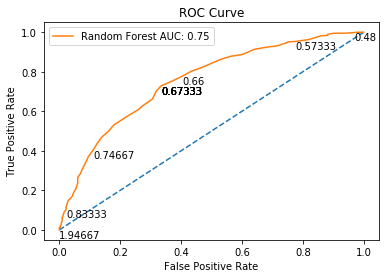

In [72]:
plot_roc(y_test1, probs, 'Random Forest')

In [80]:
start = time.time()
mlp = MLPClassifier(solver='adam', activation='relu', alpha=0.0001, hidden_layer_sizes = (64, 1), max_iter = 10000)
mlp.fit(x_train1, y_train1)

now = time.time()
print('Elapsed Time: ' + str(int(now-start)) + ' seconds')
probs_nn = mlp.predict_proba(x_test1)[:,1]

Elapsed Time: 8 seconds


max(tpr - fpr) w/ th =  0.9981069845990855


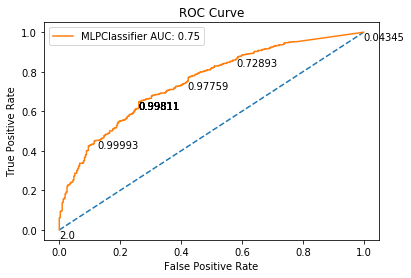

f1_score:
0.6532798484755735
precision_score:
0.6599532507066753
accuracy_score:
0.6746323529411765
Confusion Matrix:
[[232  82]
 [272 502]]
              precision    recall  f1-score   support

           0       0.46      0.74      0.57       314
           1       0.86      0.65      0.74       774

    accuracy                           0.67      1088
   macro avg       0.66      0.69      0.65      1088
weighted avg       0.74      0.67      0.69      1088



(0.6532798484755735,
 0.6599532507066753,
 0.6746323529411765,
 0.7490351223687025)

In [81]:
plot_roc(y_test1, probs_nn, 'MLPClassifier')

matrix_info(0.53, y_test1, probs_nn)

In [50]:
x = [0.781, 0.793, 0.699]
print(np.mean(x))
print(np.std(x))

0.7576666666666667
0.04177186719418815


In [30]:
start = time.time()
svc = LinearSVC(C = 0.001, loss = 'hinge', max_iter=10000)
svc = CalibratedClassifierCV(svc)
svc.fit(x_train1,y_train1)
now = time.time()
print('Elapsed Time: ' + str(int(now-start)) + ' seconds')

probs_svm = svc.predict_proba(x_test1)[:,1]
#probs_svm = svc.predict(x_test1)

Elapsed Time: 0 seconds


D:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


max(tpr - fpr) w/ th =  0.766959633437711


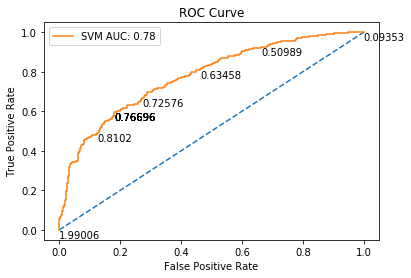

f1_score:
0.6515818676097422
precision_score:
0.6741536458333334
accuracy_score:
0.6617647058823529
Confusion Matrix:
[[267  59]
 [309 453]]
              precision    recall  f1-score   support

           0       0.46      0.82      0.59       326
           1       0.88      0.59      0.71       762

    accuracy                           0.66      1088
   macro avg       0.67      0.71      0.65      1088
weighted avg       0.76      0.66      0.68      1088



(0.6515818676097422,
 0.6741536458333334,
 0.6617647058823529,
 0.7766412250615912)

In [31]:
plot_roc(y_test1, probs_svm, 'SVM')

matrix_info(0.4135, y_test1, probs_svm)

In [25]:
params = {
    'C': [0.001, 0.01, 0.1, 1,3,5],
    'max_iter': [10000]
}

svc = LinearSVC(max_iter=10000)
cv = GridSearchCV(svc, param_grid=params, scoring='accuracy', n_jobs=-1, verbose=20, refit='accuracy', cv=5)
cv.fit(X_train,Y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:   

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=10000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=None, tol=0.0001, verbose=0),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 3, 5], 'max_iter': [10000]},
             pre_dispatch='2*n_jobs', refit='accuracy',
             return_train_score=False, scoring='accuracy', verbose=20)

In [26]:
cv_results = pd.DataFrame(cv.cv_results_)
print("best params: ", cv_results.sort_values('rank_test_score').reset_index()['params'][1])
cv_results.sort_values('rank_test_score')

best params:  {'C': 0.01, 'max_iter': 10000}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_max_iter,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.130201,0.005741,0.004400,0.003323,0.001,10000,"{'C': 0.001, 'max_iter': 10000}",0.747243,0.766544,0.750919,0.748162,0.745404,0.751654,0.007655,1
1,0.396998,0.016792,0.002601,0.000489,0.01,10000,"{'C': 0.01, 'max_iter': 10000}",0.742647,0.768382,0.747243,0.743566,0.742647,0.748897,0.009889,2
2,3.350400,0.528944,0.001600,0.000489,0.1,10000,"{'C': 0.1, 'max_iter': 10000}",0.741728,0.768382,0.745404,0.744485,0.743566,0.748713,0.009909,3
4,47.124853,1.919500,0.001199,0.000400,3,10000,"{'C': 3, 'max_iter': 10000}",0.740809,0.767463,0.746324,0.744485,0.743566,0.748529,0.009633,4
3,41.927550,2.900777,0.001401,0.000490,1,10000,"{'C': 1, 'max_iter': 10000}",0.740809,0.767463,0.746324,0.743566,0.742647,0.748162,0.009813,5
5,41.657935,2.168649,0.000600,0.000490,5,10000,"{'C': 5, 'max_iter': 10000}",0.740809,0.767463,0.743566,0.744485,0.738971,0.747059,0.010389,6


(6, 1)


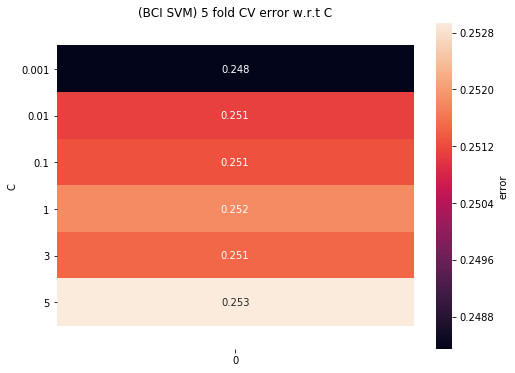

In [32]:
import seaborn as sns
C = [0.001, 0.01, 0.1, 1,3,5]
#gamma = np.power(5, np.linspace(-2,5, 10))

# Draw heatmaps for result of grid search.
def draw_heatmap(errors, D_list, title):
    plt.figure(figsize = (8,6))
    ax = sns.heatmap(errors, annot=True, fmt='.3f', yticklabels=C)
    ax.collections[0].colorbar.set_label('error')
    ax.set(ylabel='C')
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    ax.set_yticklabels(rotation=0, labels = C)
    plt.title(title)
    plt.show()

cross_val_errors = 1 - cv.cv_results_['mean_test_score'].reshape(len(C),1)
print(cross_val_errors.shape)
draw_heatmap(cross_val_errors, C, title='(BCI SVM) 5 fold CV error w.r.t C')

In [56]:
rf_heart.shape

(3, 2)

In [59]:
rf_heart[:,1]

array([0.811, 0.797, 0.739])

In [77]:
parameters = {'solver': ['adam','lbfgs'], 
              'activation': ['relu'],
              'max_iter': [10000], 
              'alpha': 10.0 ** -np.arange(1, 5), 
              'hidden_layer_sizes':[(10,1),(16,16),(10,10),(64,1),(64,64),(32,32),(32,16)]}
cv = GridSearchCV(MLPClassifier(), parameters, n_jobs=-1, cv = 5, verbose = 20)
cv.fit(x_train1,y_train1)

Fitting 5 folds for each of 56 candidates, totalling 280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:   

[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 134 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 135 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 139 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 140 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 142 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 143 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 145 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 147 tasks      | elapsed:  2.8min
[Paralle

[Parallel(n_jobs=-1)]: Done 265 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 280 out of 280 | elapsed:  5.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 280 out of 280 | elapsed:  5.1min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_iter=200,
                                     momentum=0.9, n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_sta...
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'activation': ['relu'],
                         'alpha': array([0.1   , 0.01  , 0.001 , 0.0001]),
                         'h

In [79]:
cv_results = pd.DataFrame(cv.cv_results_)
print("best params: ", cv_results.sort_values('rank_test_score').reset_index()['params'][0])
cv_results.sort_values('rank_test_score')

best params:  {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (64, 1), 'max_iter': 10000, 'solver': 'adam'}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_alpha,param_hidden_layer_sizes,param_max_iter,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
48,25.687581,4.223082,0.007302,3.660675e-03,relu,0.0001,"(64, 1)",10000,adam,"{'activation': 'relu', 'alpha': 0.0001, 'hidde...",0.728211,0.724138,0.729885,0.731034,0.732184,0.729090,0.002802,1
8,21.868452,1.776571,0.007581,7.967244e-04,relu,0.1,"(64, 64)",10000,adam,"{'activation': 'relu', 'alpha': 0.1, 'hidden_l...",0.707569,0.734483,0.719540,0.729885,0.740230,0.726333,0.011584,2
20,18.713199,4.808166,0.007381,1.954627e-03,relu,0.01,"(64, 1)",10000,adam,"{'activation': 'relu', 'alpha': 0.01, 'hidden_...",0.731651,0.727586,0.700000,0.732184,0.733333,0.724954,0.012623,3
6,26.303027,7.800243,0.005786,3.990414e-04,relu,0.1,"(64, 1)",10000,adam,"{'activation': 'relu', 'alpha': 0.1, 'hidden_l...",0.735092,0.726437,0.709195,0.727586,0.726437,0.724954,0.008515,3
15,2.483259,0.713659,0.002793,3.992568e-04,relu,0.01,"(10, 1)",10000,lbfgs,"{'activation': 'relu', 'alpha': 0.01, 'hidden_...",0.732798,0.739080,0.686207,0.706897,0.737931,0.720588,0.020788,5
9,3.374847,0.276855,0.008178,3.990653e-04,relu,0.1,"(64, 64)",10000,lbfgs,"{'activation': 'relu', 'alpha': 0.1, 'hidden_l...",0.713303,0.720690,0.706897,0.731034,0.725287,0.719439,0.008545,6
34,24.382633,8.476643,0.006584,1.354829e-03,relu,0.001,"(64, 1)",10000,adam,"{'activation': 'relu', 'alpha': 0.001, 'hidden...",0.702982,0.728736,0.698851,0.728736,0.735632,0.718980,0.015026,7
22,8.117996,0.607840,0.009974,3.025196e-03,relu,0.01,"(64, 64)",10000,adam,"{'activation': 'relu', 'alpha': 0.01, 'hidden_...",0.705275,0.703448,0.722989,0.729885,0.712644,0.714844,0.010186,8
50,9.035406,0.570909,0.007978,1.092016e-03,relu,0.0001,"(64, 64)",10000,adam,"{'activation': 'relu', 'alpha': 0.0001, 'hidde...",0.709862,0.708046,0.702299,0.716092,0.729885,0.713235,0.009414,9
14,11.309465,1.736745,0.003790,2.630431e-03,relu,0.01,"(10, 1)",10000,adam,"{'activation': 'relu', 'alpha': 0.01, 'hidden_...",0.706422,0.685057,0.714943,0.712644,0.732184,0.710248,0.015216,10


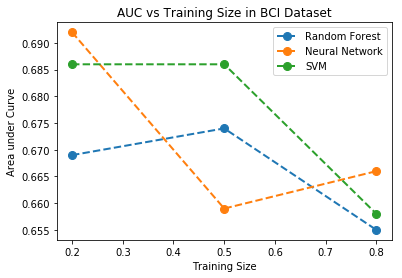

In [81]:
rf_heart = np.array([(0.2, 0.669), (0.5, 0.674), (0.8, 0.655)])
nn_heart = np.array([(0.2, 0.692), (0.5, 0.659), (0.8, 0.666)])
svm_heart = np.array([(0.2, 0.686), (0.5, 0.686), (0.8, 0.658)])

x1 = rf_heart[:,0]
y1 = rf_heart[:,1]

x2 = nn_heart[:,0]
y2 = nn_heart[:,1]

x3 = svm_heart[:,0]
y3 = svm_heart[:,1]

plt.plot(x1, y1, marker='o', linestyle='dashed', linewidth=2, markersize=8, label='Random Forest')
plt.plot(x2, y2, marker='o', linestyle='dashed', linewidth=2, markersize=8, label = 'Neural Network')
plt.plot(x3, y3, marker='o', linestyle='dashed', linewidth=2, markersize=8, label = 'SVM')
plt.xlabel('Training Size')
plt.ylabel('Area under Curve')
plt.title('AUC vs Training Size in BCI Dataset')
plt.legend()
plt.show()

In [67]:
test_scores = [0.783, 0.765, 0.758]
train_scores = [0.975, 0.929, 0.784]

In [73]:
x = ['Random Forest','Neural Network','SVM']
z = test_scores
y = train_scores
df_test = pd.DataFrame(zip(x*3, ["Test Score"]*3+["Train Score"]*3, z+y), columns=["type", "Score", "data"])

In [74]:
df_test

,type,Score,data
0,Random Forest,Test Score,0.783
1,Neural Network,Test Score,0.765
2,SVM,Test Score,0.758
3,Random Forest,Train Score,0.975
4,Neural Network,Train Score,0.929
5,SVM,Train Score,0.784


In [56]:
import seaborn as sns

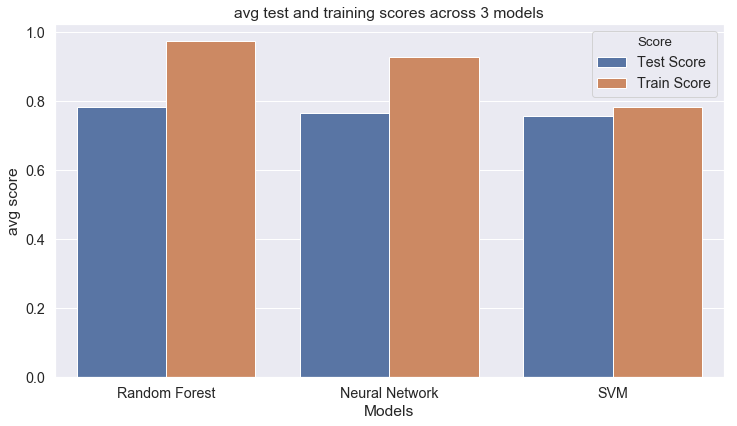

In [98]:
plt.figure(figsize=(12, 6.5))
ax = sns.barplot(x="type", hue="Score", y="data", data=df_test)
ax.set(xlabel='Models', ylabel='avg score')
sns.set(font_scale=1.3)
ax.set_title('avg test and training scores across 3 models')
plt.show()

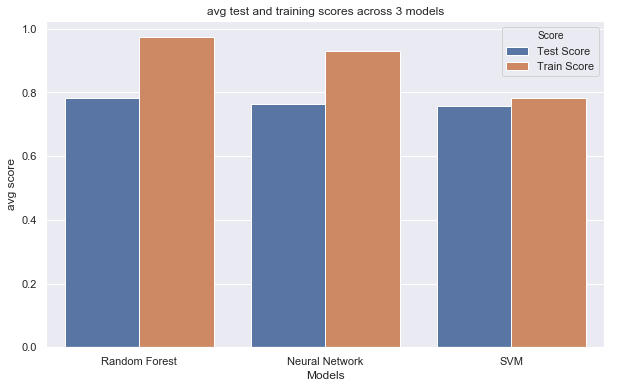

In [82]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(x="type", hue="Score", y="data", data=df_test)
ax.set(xlabel='Models', ylabel='avg score')
ax.set_title('avg test and training scores across 3 models')
plt.show()